In [10]:
# Import dependencies
import torch 
from PIL import Image
from torch import nn, save, load
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
from torcheval.metrics import MulticlassAccuracy
from torcheval.metrics.functional import multiclass_accuracy
from sklearn.model_selection import train_test_split
import math
from torchvision import transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
from tqdm import tqdm
import cv2
import random
from skimage.io import imread,imsave,imshow
from helper_functions import data_cropping

In [4]:
TEST_DIR = '../Second set/Testing'
TRAIN_DIR = '../Second set/Training'
AUGMENTED_DIR = 'Training_augmented'
IMG_SIZE = 224
CATEGORIES = ["glioma","meningioma","notumor","pituitary"]

### Load Dataset

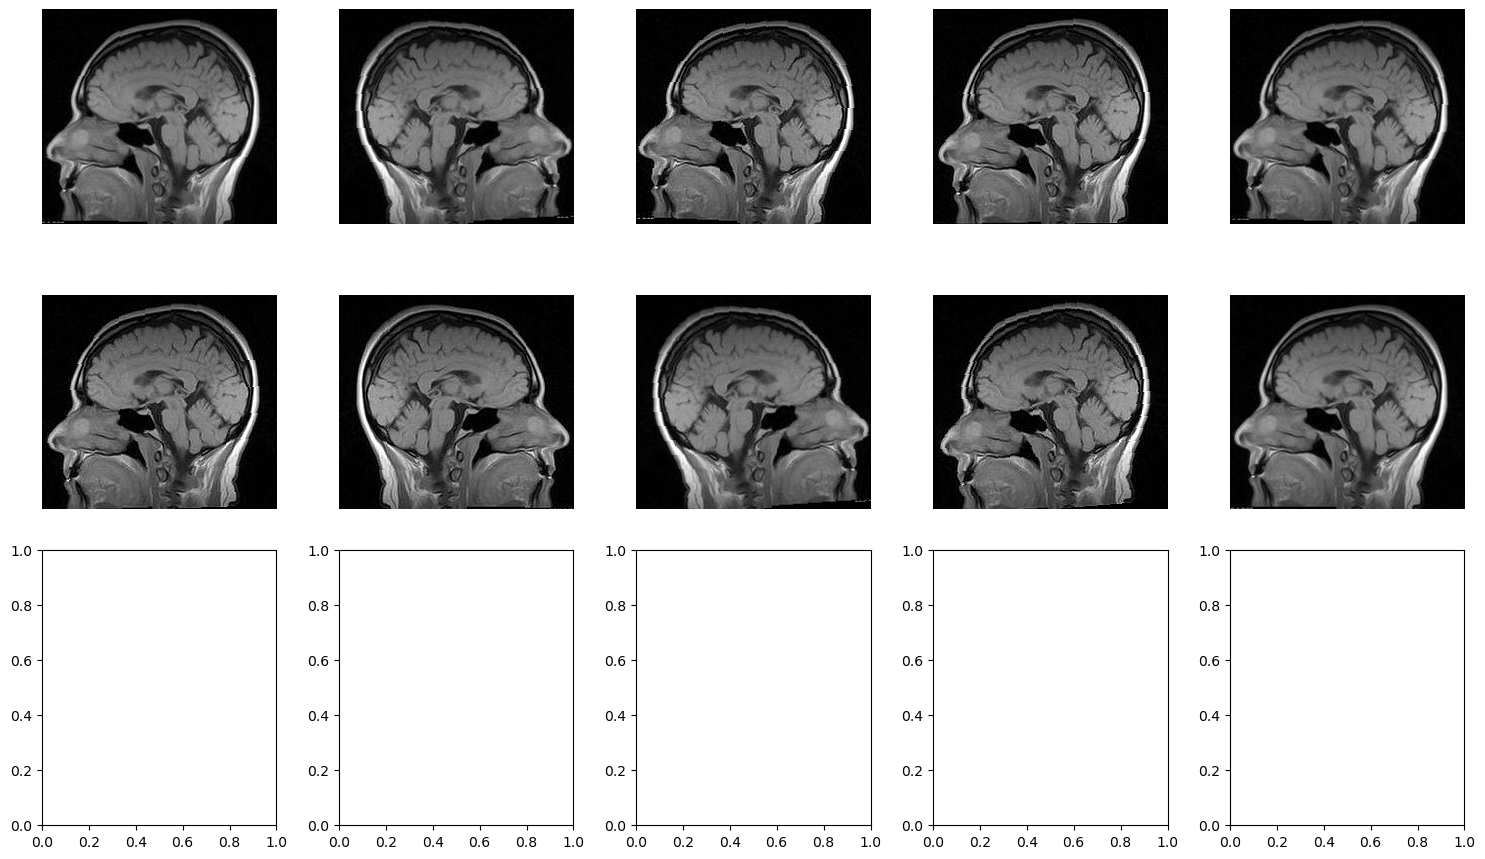

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_images(image_paths):
    num_images = len(image_paths)
    num_rows = (num_images // 5) + 1
    fig, axes = plt.subplots(num_rows, 5, figsize=(15, 3*num_rows))
    axes = axes.flatten()

    for i, image_path in enumerate(image_paths):
        if i < num_images:
            img = mpimg.imread(image_path)
            axes[i].imshow(img, cmap='gray')
            axes[i].axis('off')
        else:
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
image_paths = ['Training_augmented/no_tumor/image(99)_aug_8.png', 'Training_augmented/no_tumor/image(99)_aug_7.png', 'Training_augmented/no_tumor/image(99)_aug_6.png', 'Training_augmented/no_tumor/image(99)_aug_5.png', 'Training_augmented/no_tumor/image(99)_aug_4.png', 'Training_augmented/no_tumor/image(99)_aug_3.png', 'Training_augmented/no_tumor/image(99)_aug_2.png', 'Training_augmented/no_tumor/image(99)_aug_1.png', 'Training_augmented/no_tumor/image(99)_aug_0.png', 'Training/no_tumor/image(99).jpg']
display_images(image_paths)

In [5]:
# Training set

training_data_no_augmentation=[]

def create_dataset():
    for category in CATEGORIES:
        path = os.path.join(TRAIN_DIR,category)
        class_num = CATEGORIES.index(category)
        for img in tqdm(os.listdir(path)):
            if (img != ".ipynb_checkpoints"):
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)
                img_array = data_cropping(img_array)
                if (img_array is not None):
                    img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                    training_data_no_augmentation.append([img_array, class_num])

    random.shuffle(training_data_no_augmentation)


create_dataset()
print("Number of samples in training dataset:", len(training_data_no_augmentation))


100%|██████████████████████████████████████| 1457/1457 [00:02<00:00, 499.70it/s]

Number of samples in training dataset: 5712


In [6]:
training_data = training_data_no_augmentation

In [4]:
# Data augmentation 

training_data = training_data_no_augmentation

# Define data augmentation transformations
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),     
    transforms.RandomAdjustSharpness(2)
])

def create_dataset():
    for category in CATEGORIES:
        path = os.path.join(TRAIN_DIR, category)
        augmented_path = os.path.join(AUGMENTED_DIR, category)  # Path to save augmented images
        if not os.path.exists(augmented_path):
            os.makedirs(augmented_path)
        class_num = CATEGORIES.index(category)
        for img in tqdm(os.listdir(path)):
            if img != ".ipynb_checkpoints":
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                img_pil = Image.fromarray(img_array)  # Convert NumPy array to PIL Image
                num_augmentations = 3 if class_num in [0, 1, 3] else 6
                for i in range(num_augmentations):  
                    img_tensor = data_transforms(img_pil)  
                    augmented_img_name = f"{img.split('.')[0]}_aug_{i}.png"  
                    augmented_img_path = os.path.join(augmented_path, augmented_img_name)
                    augmented_img_np = np.array(img_tensor) 
                    cv2.imwrite(augmented_img_path, augmented_img_np)  # Save augmented image
                    augmented_img_np = data_cropping(augmented_img_np)
                    if augmented_img_np is not None:
                        augmented_img_np = cv2.resize(augmented_img_np, (IMG_SIZE, IMG_SIZE))
                        training_data.append([augmented_img_np, class_num])
    
    random.shuffle(training_data)
    
create_dataset()
print("Number of samples in training dataset:", len(training_data))

100%|█████████████████████████████████████████| 827/827 [00:11<00:00, 74.77it/s]

Number of samples in training dataset: 12665


In [7]:
# Create Testing set

training_data = training_data_no_augmentation
def create_dataset():
    for category in CATEGORIES:
        path = os.path.join(AUGMENTED_DIR,category)
        class_num = CATEGORIES.index(category)
        for img in tqdm(os.listdir(path)):
            if (img != ".ipynb_checkpoints"):
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)
                training_data.append([img_array, class_num])
            
    random.shuffle(training_data)


create_dataset()
print("Number of samples in training dataset:", len(training_data))


FileNotFoundError: [Errno 2] No such file or directory: 'Training_augmented/glioma'

In [23]:
testing_data=[]

def create_dataset_test():
    for category in CATEGORIES:
        path = os.path.join(TEST_DIR,category)
        class_num = CATEGORIES.index(category)
        for img in tqdm(os.listdir(path)):
            if (img != ".ipynb_checkpoints"):
                img_array = cv2.imread(os.path.join(path, img) ,cv2.IMREAD_GRAYSCALE)
                img_array = data_cropping(img_array)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                testing_data.append([new_array, class_num])
            
    random.shuffle(testing_data)


create_dataset_test()
print(len(testing_data))


100%|████████████████████████████████████████| 300/300 [00:00<00:00, 518.25it/s]

1311


In [18]:
# The input needs to be a float (bc during the computing, the operations are made on floats = parameters of the NN are floats)
shape=(-1, 1, IMG_SIZE, IMG_SIZE)
train_X = np.array([d[0] for d in training_data], dtype=np.float32).reshape(shape)
train_y = np.array([d[1] for d in training_data])
test_X = np.array([d[0] for d in testing_data], dtype=np.float32).reshape(shape)
test_y = np.array([d[1] for d in testing_data])

In [19]:
batch_size = 16
train_X = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_y)
# Stratify to make sure that we take images from all classes of tumors equally
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.15, random_state=42, stratify=train_y)

train_dataset = torch.utils.data.TensorDataset(train_X, train_y)
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

test_X = torch.from_numpy(test_X)
test_y = torch.from_numpy(test_y)
test_dataset = torch.utils.data.TensorDataset(test_X, test_y)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

In [20]:
def calc_n_params(img_side, last_channels, n_convmax):
    for i in range(n_convmax):
        img_side = math.floor(((img_side-4)/2)+1)
    return img_side*img_side*last_channels    

#### TEST OF NETWORKS

###### NETWORK 1

In [12]:
calc_n_params(IMG_SIZE,32,3)

6272

###### NETWORK 2

In [50]:
# NETWORK 2
# AJouter batch norm
class ImageClassifier(nn.Module): 
    # create the model where we stack layers
    def __init__(self):
        super().__init__()
        # We use sequential API because it allows us to build the model mayer by layer by stacking them
        # We use CNN (nn,.Conv2d(1 bc our input is black and white, 32 filters of shape/kernels or dimension 3 by 3) 
        # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        #https://www.simplilearn.com/tutorials/deep-learning-tutorial/convolutional-neural-network#:~:text=Flattening%20is%20used%20to%20convert,layer%20to%20classify%20the%20image.
        self.model = nn.Sequential(
            # First layer
            nn.Conv2d(1, 32, (3,3)), 
            # Activation fonction
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # Second layer: 32 as the imput channel, 64 as output
            nn.Conv2d(32, 64, (3,3)), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # Third layer
            nn.Conv2d(64, 128, (3,3)), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # Flatten the layers because we apply a linear filter afterwards
            nn.Flatten(), 
            #215296
        
            # For 224*224 images
            nn.Linear(26*26*128, 256),  # Added first fully connected layer
            # For 512*512
            #nn.Linear(62*62*64,128),
            nn.ReLU(),                # Added ReLU activation function
            nn.Linear(256, 4)         # Output layer
        )

    #add fully connected
    def forward(self, x): 
        return self.model(x)

###### NETWORK 3

In [12]:
# NETWORK 3
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # Second convolutional layer
            nn.Conv2d(32, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # Third convolutional layer
            nn.Conv2d(32, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # Flatten layer
            nn.Flatten(),
 
            # Output layer
            nn.Linear(calc_n_params(IMG_SIZE,32,3), 4)
        )

    def forward(self, x):
        return self.model(x)

##### Network 4

In [76]:
# NETWORK 4
class ImageClassifier4(nn.Module): 
    # create the model where we stack layers
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # First layer
            nn.Conv2d(1, 32, (3,3)), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            # Second layer
            nn.Conv2d(32, 64, (3,3)), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            # Third layer
            nn.Conv2d(64, 128, (3,3)), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            # Flatten the layers because we apply a linear filter afterwards
            nn.Flatten(), 

            nn.Linear(calc_n_params(IMG_SIZE,128,3), 1024),  # Add fully connected layer
            nn.ReLU(),                # Added Softmax activation function
            
            nn.Linear(1024,4),  # Add fully connected layer
            nn.Softmax(),                # Added Softmax activation function
        )

    #add fully connected
    def forward(self, x): 
        return self.model(x)

In [88]:
# Network 5
class ImageClassifier(nn.Module): 
    # create the model where we stack layers
    def __init__(self):
        super().__init__()
        # We use sequential API because it allows us to build the model mayer by layer by stacking them
        # We use CNN (nn,.Conv2d(1 bc our input is black and white, 32 filters of shape/kernels or dimension 3 by 3) 
        # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        #https://www.simplilearn.com/tutorials/deep-learning-tutorial/convolutional-neural-network#:~:text=Flattening%20is%20used%20to%20convert,layer%20to%20classify%20the%20image.
        self.model = nn.Sequential(
            # First layer
            nn.Conv2d(1, 32, (3,3)), 
            # Activation fonction
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # Second layer: 32 as the imput channel, 64 as output
            nn.Conv2d(32, 64, (3,3)), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # Third layer
            nn.Conv2d(64, 128, (3,3)), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # Flatten the layers because we apply a linear filter afterwards
            nn.Flatten(), 
            #215296
        
            # For 224*224 images
            nn.Linear(26*26*128, 1024),  # Added first fully connected layer
            nn.ReLU(),                # Added ReLU activation function
            nn.Linear(1024, 128), 
            nn.ReLU(),                # Added ReLU activation function
            nn.Linear(128, 4)         # Output layer
        )

    #add fully connected
    def forward(self, x): 
        return self.model(x)

### TRAINING

In [24]:
%%time
maxval = -1

# Tabs for Validation and Training data for graphs
val_loss = []
val_acc = []
train_loss = []
train_acc = []

# Instance of the neural network, loss, optimizer 
clf = ImageClassifier()
# Adam(classification parameters, speed of training)
#lr=1e-3
opt = Adam(clf.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Training flow 
#  epoch refers to one cycle through the full training dataset
for epoch in range(9): # train for __ epochs
    # batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters.
    n_batch = 0
    training_loss = 0
    training_accuracy = 0
    for batch in tqdm(train_loader):
        n_batch += 1
        X,y = batch
        opt.zero_grad()
        
        # Predictions for batch
        yhat = clf(X)
        loss = loss_fn(yhat, y)
        training_loss += loss.item()
        acc = multiclass_accuracy(yhat, y)
        training_accuracy += acc.item()
        
        # Apply backprop 
        loss.backward()
        opt.step() 

    training_loss = training_loss / n_batch
    training_accuracy = training_accuracy / n_batch
    print(f"Epoch:{epoch} loss is {training_loss}, accuracy is {training_accuracy}")
    
    train_loss.append(training_loss)
    train_acc.append(training_accuracy)
    
    with torch.no_grad():
        # Validation for each epoch (using the validation set created earlier)
        predictions = clf(val_X)
        validation_accuracy = multiclass_accuracy(predictions, val_y).item()
        validation_loss = loss_fn(predictions, val_y).item()
        print(f"Epoch:{epoch} validation loss is {validation_loss}, validation accuracy is {validation_accuracy}")
        val_loss.append(validation_loss)
        val_acc.append(validation_accuracy)
        
    if (validation_accuracy>maxval):
        maxval=validation_accuracy
        torch.save({
            'epoch': epoch,
            'model_state_dict': clf.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'loss': loss,
            },f"checkpoints/clf_best_model_newset_random")

100%|█████████████████████████████████████████| 304/304 [01:34<00:00,  3.23it/s]


Epoch:0 loss is 1.4882711939709752, accuracy is 0.6674988252159796
Epoch:0 validation loss is 0.5539219975471497, validation accuracy is 0.7946324348449707


100%|█████████████████████████████████████████| 304/304 [01:35<00:00,  3.17it/s]


Epoch:1 loss is 0.46094034331556605, accuracy is 0.826832706794927
Epoch:1 validation loss is 0.6276304721832275, validation accuracy is 0.7526254653930664


100%|█████████████████████████████████████████| 304/304 [01:36<00:00,  3.17it/s]


Epoch:2 loss is 0.3329360005323236, accuracy is 0.8782307331107164
Epoch:2 validation loss is 0.5398238897323608, validation accuracy is 0.8004667162895203


100%|█████████████████████████████████████████| 304/304 [01:35<00:00,  3.18it/s]


Epoch:3 loss is 0.23572293242844017, accuracy is 0.9119478383738744
Epoch:3 validation loss is 0.6698709726333618, validation accuracy is 0.8063010573387146


100%|█████████████████████████████████████████| 304/304 [01:35<00:00,  3.18it/s]


Epoch:4 loss is 0.1948105302090928, accuracy is 0.9294819078947368
Epoch:4 validation loss is 0.6594961881637573, validation accuracy is 0.8273045420646667


100%|█████████████████████████████████████████| 304/304 [01:35<00:00,  3.19it/s]


Epoch:5 loss is 0.1410086710296271, accuracy is 0.9500411184210527
Epoch:5 validation loss is 0.6565600037574768, validation accuracy is 0.8471412062644958


100%|█████████████████████████████████████████| 304/304 [01:36<00:00,  3.16it/s]


Epoch:6 loss is 0.11344489399471058, accuracy is 0.9588228383738744
Epoch:6 validation loss is 0.7703343033790588, validation accuracy is 0.8588098287582397


100%|█████████████████████████████████████████| 304/304 [01:35<00:00,  3.20it/s]


Epoch:7 loss is 0.10842716229598481, accuracy is 0.9617011278475586
Epoch:7 validation loss is 0.8385055065155029, validation accuracy is 0.8494749069213867


100%|█████████████████████████████████████████| 304/304 [01:35<00:00,  3.19it/s]


Epoch:8 loss is 0.12639057950153934, accuracy is 0.9606731673212427
Epoch:8 validation loss is 0.7243303656578064, validation accuracy is 0.8658109903335571
CPU times: user 30min 9s, sys: 7min 48s, total: 37min 57s
Wall time: 19min 30s


#### Train with early stopping

In [15]:
%%time
# Training with early stopping
maxval = -1
# Instance of the neural network, loss, optimizer 
clf = ImageClassifier()
# Adam(classification parameters, speed of training)
#lr=1e-3
opt = Adam(clf.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

# Define early stopping criteria
patience = 5  # Number of epochs to wait for improvement
counter = 0   # Counter to keep track of epochs with no improvement
best_val_loss = float('inf')  # Best validation loss

# Training flow 
#  epoch refers to one cycle through the full training dataset
for epoch in range(10): # train for 10 epochs
    # batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters.
    n_batch = 0
    training_loss = 0
    training_acc = 0
    for batch in train_loader:
        n_batch += 1
        X, y = batch
        opt.zero_grad()
        
        # Predictions for batch
        yhat = clf(X)
        loss = loss_fn(yhat, y)
        training_loss += loss.item()
        acc = multiclass_accuracy(yhat, y)
        training_acc += acc.item()

        # Apply backprop 
        loss.backward()
        opt.step() 

    training_loss = training_loss / n_batch
    training_acc = training_acc / n_batch
    print(f"Epoch:{epoch} loss is {training_loss}, accuracy is {training_acc}")
    
    # Calculate validation loss and accuracy
    with torch.no_grad():
        # Validation for each epoch (using the validation set created earlier)
        predictions = clf(val_X)
        val_accuracy = multiclass_accuracy(predictions, val_y).item()
        val_loss = loss_fn(predictions, val_y).item()
        print(f"Epoch:{epoch} validation loss is {val_loss}, validation accuracy is {val_accuracy}")
    
    # Check if validation loss improved, if not, increase counter
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # Save the best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': clf.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'loss': loss,
        }, f"checkpoints/clf_best_model3_20e")
    else:
        counter += 1
        # If no improvement for 'patience' epochs, stop training
        if counter >= patience:
            print("Early stopping...")
            break

/Users/claraneuburger/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch:0 loss is 1.3650155795084966, accuracy is 0.3546498146924106
Epoch:0 validation loss is 1.3591200113296509, validation accuracy is 0.39443156123161316
Epoch:1 loss is 1.3569818425488163, accuracy is 0.41059833029647924
Epoch:1 validation loss is 1.358525037765503, validation accuracy is 0.4199535846710205
Epoch:2 loss is 1.3544306646693836, accuracy is 0.4487476809458299
Epoch:2 validation loss is 1.3563652038574219, validation accuracy is 0.4060324728488922
Epoch:3 loss is 1.3520985408262773, accuracy is 0.48689703159518055
Epoch:3 validation loss is 1.3521190881729126, validation accuracy is 0.5104408264160156
Epoch:4 loss is 1.3496442011424474, accuracy is 0.5226113173094663
Epoch:4 validation loss is 1.3529518842697144, validation accuracy is 0.5011600852012634



KeyboardInterrupt



#### Testing

In [34]:
torch.save({
            'epoch': epoch,
            'model_state_dict': clf.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'loss': loss,
            },f"checkpoints/clf-e{epoch}CNN_3Conv32_64_128_2fc_128_4_e15")

In [25]:
metric = MulticlassAccuracy()
predictions = clf(test_X)
metric.update(predictions, test_y)
metric.compute()

tensor(0.8680)

In [22]:
checkpoint = torch.load("best-models-no-aug/model_3conv_2fc_64ls_noAug")

model = ImageClassifier()
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


KeyError: 'model'

In [19]:
metric = MulticlassAccuracy()
predictions = model(test_X)
metric.update(predictions.argmax(axis=-1), test_y)
metric.compute()

tensor(0.6853)

In [20]:
import pickle
data_3Conv_1Dense_20e_128size = [train_loss, train_acc, val_loss, val_acc]
with open('data_3Conv_1Dense_15e_128size_aug10.pkl', 'wb') as f:
    pickle.dump(data_3Conv_1Dense_20e_128size, f)

In [21]:
# To load the data from a file 
with open('data_3Conv_1Dense_20e_128size.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

In [23]:
print(loaded_data)

[[2.0457943778110903, 0.5774296860507482, 0.4260274091141713, 0.2918177581835522, 0.24678335508014437, 0.17610753725351985, 0.12222311022593822, 0.11484017373595436, 0.07865708580598496, 0.07914815046855017, 0.07640658271515245, 0.07844574441807954, 0.050882731737440866, 0.056072896495146275, 0.0486467282187883, 0.034829686035965896, 0.05937996424933363, 0.0536363461019848, 0.07353606944571452, 0.06356794331766721], [0.5963055775155146, 0.764899265557918, 0.8289871973241781, 0.884031361627787, 0.9074905717737289, 0.9332820564898862, 0.956418717792461, 0.9576344778964613, 0.9708713774597801, 0.9733277093375093, 0.9733897379912664, 0.9742085152838428, 0.9813790193811774, 0.9811060936169853, 0.9843067685589519, 0.9871724890829694, 0.9811060936169853, 0.9817139737991266, 0.9757096069868996, 0.9819868995633187], [0.6436281800270081, 0.5173407196998596, 0.5062114596366882, 0.4424420893192291, 0.41883382201194763, 0.42427730560302734, 0.4942474961280823, 0.35870561003685, 0.41495421528816223,

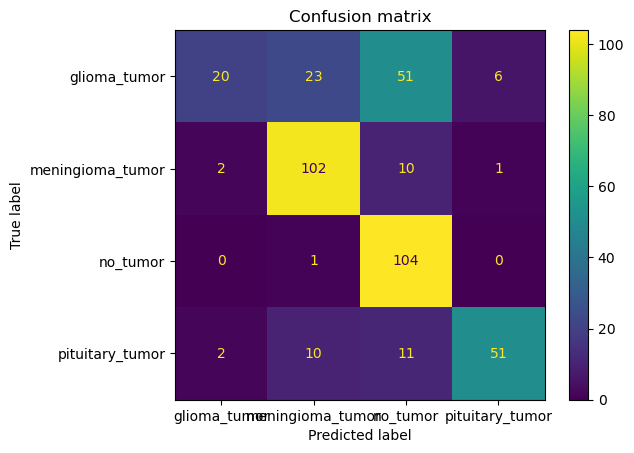

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(test_y, predictions.argmax(axis=-1).detach().numpy())
ConfusionMatrixDisplay(cm, display_labels=CATEGORIES).plot()
plt.title('Confusion matrix')
plt.savefig('Confusion_matrix_20e_3Conv_1Dense_aug_128size.png')


In [28]:
import tensorflow as tf


train_X_t = tf.convert_to_tensor(train_X, dtype=tf.float32)
#train_y_t = tf.convert_to_tensor(train_y, dtype=tf.float32)
train_y_t = tf.one_hot(train_y, depth=4)
val_y_t = tf.one_hot(val_y, depth=4)
test_y_t = tf.one_hot(test_y,depth =4)
val_X_t = tf.convert_to_tensor(val_X, dtype=tf.float32)
#val_y_t = tf.convert_to_tensor(val_y, dtype=tf.float32)
test_X_t = tf.convert_to_tensor(test_X, dtype=tf.float32)
#test_y_t = tf.convert_to_tensor(test_y, dtype=tf.float32)

train_X_t = np.reshape(train_X_t, (-1, 224, 224, 1))
#train_y_t = np.reshape(train_y_t, (-1, 224, 224, 1))
test_X_t = np.reshape(test_X_t, (-1, 224, 224, 1))
#test_y_t = np.reshape(test_y_t, (-1, 224, 224, 1))
val_X_t = np.reshape(val_X_t, (-1, 224, 224, 1))
#val_y_t = np.reshape(val_y_t, (-1, 224, 224, 1))


## NEW MODEL TRAINING

## Try for Hyper parameter search : Bayesian Optimizer

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from bayes_opt import BayesianOptimization

class MyModel(nn.Module):
    def __init__(self, num_conv_layers, num_fc_layers, layer_size):
        super(MyModel, self).__init__()
        self.num_conv_layers = num_conv_layers
        self.num_fc_layers = num_fc_layers
        self.layer_size = layer_size
        self.conv_layers = self._create_conv_layers()
        self.output_layers = self._create_output_layers()
        self.flatten = nn.Flatten()
    
    def _create_conv_layers(self):
        layers = []
        layers.append(nn.Conv2d(1, self.layer_size, kernel_size=3))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2))
        for _ in range(self.num_conv_layers - 1):
            layers.append(nn.Conv2d(self.layer_size, self.layer_size, kernel_size=3))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2))
        return nn.Sequential(*layers)

    def _create_output_layers(self):
        layers = []
        input_size = calc_n_params(IMG_SIZE, self.layer_size, self.num_conv_layers)
        for _ in range(self.num_fc_layers - 1):
            layers.append(nn.Linear(input_size, self.layer_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))
            input_size = self.layer_size
        layers.append(nn.Linear(input_size, 4))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.output_layers(x)
        return x

# Define the training function
def train_model(learning_rate, batch_size):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    batch_size = int(batch_size)
    # Define the neural network
    model = MyModel(3, 1, 64).to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    print(learning_rate)
    print(batch_size)
    # Training loop
    for epoch in range(15):
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    with torch.no_grad():
        model.eval()
        outputs = model(X_test_tensor.to(device))
        _, predicted = torch.max(outputs, 1)
        accuracy = accuracy_score(y_test, predicted.cpu().numpy())

    return accuracy

# Bayesian optimization
optimizer = BayesianOptimization(
    f=train_model,
    pbounds={'learning_rate': (1e-5, 1e-1), 'batch_size': (16, 96)},
    random_state=42,
)

optimizer.maximize(init_points=5, n_iter=10)

# Print best hyperparameters found
print("Best hyperparameters:", optimizer.max)

|   iter    |  target   | batch_... | learni... |
-------------------------------------------------
0.09507192349792752
45


 87%|█████████████████████████████████████▍     | 67/77 [01:27<00:13,  1.30s/it]


KeyboardInterrupt: 